# Pronóstico de series de tiempo con DeepAR

DeepAR es un algoritmo supervisado para el pronóstico de series de tiempo escalares. En este cuaderno demostraremos como preparar un conjunto de datos para entrenar DeepAR y como utilizar el modelo entrenado para inferencia.

En este laboratorio utilizaremos el conjunto de datos [Deutsche Börse](https://registry.opendata.aws/deutsche-boerse-pds/). El uso de este conjunto de datos es puramente ilustrativo.

Comenzaremos importando las librerías que usaremos durante el laboratorio:

- [NumPy](https://numpy.org/doc/) - Paquete para computo científico dentro de Python.
- [pandas](https://pandas.pydata.org/docs/index.html) - Herramienta de código abierto utilizada para manipulación de datos.
- [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) - Kit de desarrollo de software para servicios de AWS.
- [matplotlib](https://matplotlib.org/) - Librería para generación de gráficos con Python.
- [SageMaker](https://sagemaker.readthedocs.io/en/stable/index.html) - Kit de desarrollo de software para Amazon SageMaker.

Finalmente importaremos las funciones utilitarias dentro del archivo util.py, estas funciones simplificaran la copia y carga del conjunto de datos XETRA.

In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import boto3
import sagemaker
import util
from datetime import date
from sagemaker import get_execution_role

## Preparación

Lo primero que realizaremos en este laboratorio es establecer variables que nos permitirán controlar el lugar donde almacenaremos los datos:

- ```prefix``` - Prefijo del balde de Amazon Simple Storage Service.
- ```bucket``` - Nombre del balde de Amazon Simple Storage Service.
- ```role``` - Rol de ejecución de Amazon SageMaker.
- ```s3_data_path``` - Ruta donde almacenaremos nuestros datos.
- ```s3_output_path``` - Ruta donde almacenaremos la salida de nuestros procesos.

<details><summary>Tip</summary>

El balde y el rol lo podemos obtener del object ```sagemaker.Session()``` y el método ```get_execution_role``` respectivamente.
</details>

<details><summary>Código</summary>

```python
prefix = 'sagemaker/DeepAR-securities'

session = sagemaker.Session()
role = get_execution_role()
bucket = session.default_bucket()

s3_data_path = f'{bucket}/data'
s3_output_path = f'{bucket}/output'
```
</details>

In [2]:
prefix = 'sagemaker/DeepAR-securities'

session = sagemaker.Session()
role = get_execution_role()
bucket = session.default_bucket()

s3_data_path = f'{prefix}/data'
s3_output_path = f'{prefix}/output'

### Contenedor de DeepAR

Ahora configuraremos el URI del contender con el algoritmo de DeepAR en la variable ```image_uri```. Para esto utilizaremos el SDK de SageMaker:

```python

from sagemaker.image_uris import retrieve
```

<details><summary>Tip</summary>

```retrieve``` recibe como parámetros el nombre del algoritmo y el nombre de la región donde se ejecutará el entrenamiento, en este caso *forecasting_deepar* y la región podemos obtenerla de la sesión de boto3.
</details>

<details><summary>Código</summary>

```python
from sagemaker.image_uris import retrieve

image_uri = retrieve('forecasting-deepar', boto3.Session().region_name)
```
</details>

In [3]:
from sagemaker.image_uris import retrieve

image_uri = retrieve('forecasting-deepar', boto3.Session().region_name)

## Obtención de datos

El conjunto de datos que utilizaremos para este laboratorio contiene información en resolución de 1 minuto. En este laboratorio obtendrémos información de dos meses para entrenar nuestro modelo.
**NOTA. En caso de experimentar con más datos es probable requerir una instancia con más capacidad de memoria.**

Este set de datos se encuentra localizado en ```s3://deutsche-boerse-xetra-pds/```, se encuentra dividido por día hábil y por hora. Para facilitar la copia y carga de información se incluye en el workshop el archivo ```util.py```.

In [4]:
# Cliente de Amazon Simple Storage Service
s3_client = boto3.client('s3')

# Balde origen de XETRA
source_bucket = 'deutsche-boerse-xetra-pds'

# Rango de fechas para obtener los datos
start_date = date.fromisoformat('2021-10-01')
end_date = date.fromisoformat('2022-03-01')

# Días hábiles
days = util.week_days(start_date, end_date)

# Prefijo donde almacenaremos los datos
dest_prefix = f'{s3_data_path}/raw'

# Copia de objetos del bucket origen al bucket destino
object_keys = util.copy_objects(s3_client, source_bucket, bucket, dest_prefix, days)

# Finalmente cargaremos los datos en un DataFrame de pandas
df = util.create_dataframe(s3_client, bucket, object_keys)

## Exploración de datos

Una vez que realizamos la copia de los datos a nuestro balde de S3 y los cargamos en un solo objeto de pandas, exploremos el conjunto de datos para poder prepararlo para entrenar el modelo.

El diccionario de datos perteneciente a XETRA es el siguiente:

| Columna | Descripción | Tipo |
|---------|-------------|------|
|ISIN|ISIN del instrumento|string|
|Mnemonic|Simbolo bursatil|string|
|SecurityDesc|Descripción del instrumento|string|
|SecurityType|Tipo del instrumento|string|
|Currency|Moneda del instrumento|string|
|SecurityID|Identificador del instrumento|int|
|Date|Fecha del muestreo|date|
|Time|Hora del muestreo|time (hh:mm)|
|StartPrice|Precio de inicio del instrumento en el periodo|float|
|MaxPrice|Precio máximo del instrumento en el periodo|float|
|MinPrice|Precio mínimo del instrumento en el periodo|float|
|EndPrice|Precio al final del periodo|float|
|TradedVolume|Valor total negociado|float|
|NumberOfTrades|Total de transacciones durante el periodo|int|


In [5]:
df.head(10)

,ISIN,Mnemonic,SecurityDesc,SecurityType,Currency,SecurityID,Date,Time,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades
0,DE000A0DJ6J9,S92,SMA SOLAR TECHNOL.AG,Common stock,EUR,2504287,2021-10-01,07:00,36.640,36.64,36.200,36.200,2142,14
1,DE000A0HN5C6,DWNI,DEUTSCHE WOHNEN SE INH,Common stock,EUR,2504314,2021-10-01,07:00,52.900,52.94,52.900,52.920,8388,7
2,DE000A0JL9W6,VBK,VERBIO VER.BIOENERGIE ON,Common stock,EUR,2504343,2021-10-01,07:00,56.100,56.10,55.600,55.600,2441,7
3,DE000A0LD2U1,AOX,ALSTRIA OFFICE REIT-AG,Common stock,EUR,2504379,2021-10-01,07:00,15.600,15.61,15.470,15.480,10449,27
4,DE000A0LD6E6,GXI,GERRESHEIMER AG,Common stock,EUR,2504380,2021-10-01,07:00,84.200,84.20,84.200,84.200,172,1
5,DE000A0Z2ZZ5,FNTN,FREENET AG NA O.N.,Common stock,EUR,2504438,2021-10-01,07:00,22.440,22.49,22.400,22.490,10039,23
6,DE000A1EWWW0,ADS,ADIDAS AG NA O.N.,Common stock,EUR,2504471,2021-10-01,07:00,270.000,270.00,267.750,268.050,13272,128
7,DE000A1J5RX9,O2D,TELEFONICA DTLD HLDG NA,Common stock,EUR,2504492,2021-10-01,07:00,2.392,2.40,2.382,2.396,254668,49
8,DE000A1ML7J1,VNA,VONOVIA SE NA O.N.,Common stock,EUR,2504501,2021-10-01,07:00,51.660,51.66,51.340,51.500,36064,75
9,DE000A1X3XX4,DIC,DIC ASSET AG NA O.N.,Common stock,EUR,2504532,2021-10-01,07:00,15.290,15.29,15.090,15.090,2346,12


## Preparación de datos

En este laboratorio lo que buscamos predecir es la cantidad de operaciones de compra/venta para un intrumento bursatil en un tiempo del día. Pare este laboratorio utilizaremos los instrumentos: **IFX, VOW3, SAP, DBK, SIE, BAS, DHER, BMW, DTE, LIN, LHA, CBK, DPW, BAYN, ADS, ALV, MBG, HFG, CON, ENR**

El algoritmo DeepAR recibe como entrada series de tiempo para realizar el entrenamiento, actualmente nuestro set de datos no se encuentra en esta estructura.

Al tener un conjunto de datos relativamente grande, lo primero que haremos es utilizar solo la información necesaria, para esto deshecharemos las columnas **ISIN, SecurityDesc, SecurityType, Currency, SecurityID, StartPrice, MaxPrice, MinPrice, EndPrice y TradedVolume**.

<details><summary>Tip</summary>

Podemos utilizar el método ```drop``` del ```DataFrame``` de pandas con los argumentos ```axis=1``` para afectar las columnas y ```inplace=True``` para realizarlo sobre el objeto y no generar una copia del mismo.
</details>

<details><summary>Código</summary>

```python
mnemonics = ['IFX', 'VOW3', 'SAP', 'DBK', 'SIE', 'BAS', 'DHER', 'BMW', 'DTE', 'LIN',
             'LHA', 'CBK', 'DPW', 'BAYN', 'ADS', 'ALV', 'MBG', 'HFG', 'CON', 'ENR']
df = df[df['Mnemonic'].isin(mnemonics)]
df.drop(['ISIN', 'SecurityDesc', 'SecurityType', 'Currency', 'SecurityID',
         'StartPrice', 'MaxPrice', 'MinPrice', 'EndPrice', 'TradedVolume'],
        axis=1, inplace=True)
df.head(10)
```
</details>

In [6]:
mnemonics = ['IFX', 'VOW3', 'SAP', 'DBK', 'SIE', 'BAS', 'DHER', 'BMW', 'DTE', 'LIN',
             'LHA', 'CBK', 'DPW', 'BAYN', 'ADS', 'ALV', 'MBG', 'HFG', 'CON', 'ENR']
df = df[df['Mnemonic'].isin(mnemonics)]
df.drop(['ISIN', 'SecurityDesc', 'SecurityType', 'Currency', 'SecurityID',
         'StartPrice', 'MaxPrice', 'MinPrice', 'EndPrice', 'TradedVolume'],
        axis=1, inplace=True)
df.head(10)

,Mnemonic,Date,Time,NumberOfTrades
6,ADS,2021-10-01,07:00,128
12,BAYN,2021-10-01,07:00,136
13,CBK,2021-10-01,07:00,77
36,DTE,2021-10-01,07:00,59
66,LHA,2021-10-01,07:00,50
67,ALV,2021-10-01,07:00,176
73,DHER,2021-10-01,07:00,133
78,HFG,2021-10-01,07:00,51
91,ENR,2021-10-01,07:00,57
109,ADS,2021-10-01,07:01,36


Ahora necesitamos generar una nueva columna que podamos utilizar como indice para nuestra serie de tiempo, contamos con las columnas ```Date``` y ```Time``` con formato ```hh:mm```. Concatenaremos estas dos columnas en una nueva columna llamada ```Timestamp```.

<details><summary>Tip</summary>

Pandas provee diferentes funciones para poder realizar transformación de datos, en este caso podemos utilizar ```to_datetime```, esta función puede transformar fechas en formato ISO ```YYYY-MM-DD hh:mm:ss```, lo que significa que primero tendrémos que concatenar la fecha y hora y agregar los segundos en cero.
</details>

<details><summary>Código</summary>

```python
df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'] + ':00')
df.head()
```
</details>

In [7]:
df['Timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'] + ':00')
df.head()

,Mnemonic,Date,Time,NumberOfTrades,Timestamp
6,ADS,2021-10-01,07:00,128,2021-10-01 07:00:00
12,BAYN,2021-10-01,07:00,136,2021-10-01 07:00:00
13,CBK,2021-10-01,07:00,77,2021-10-01 07:00:00
36,DTE,2021-10-01,07:00,59,2021-10-01 07:00:00
66,LHA,2021-10-01,07:00,50,2021-10-01 07:00:00


Ahora podemos eliminar las columnas ```Date``` y ```Time```, y asegurarnos que el tipo de dato de ```NumberOfTrades``` sea correcto.

<details><summary>Tip</summary>

Para eliminar las columnas podemos seguir los pasos previos ahora. Para verificar los tipos de datos podemos imprimir el objeto ```dtypes``` del ```DataFrame```.
</details>

<details><summary>Código</summary>

```python
df.drop(['Date', 'Time'], axis=1, inplace=True)
print(df.dtypes)
```
</details>

In [8]:
df.drop(['Date', 'Time'], axis=1, inplace=True)
print(df.dtypes)

Mnemonic                  object
NumberOfTrades            object
Timestamp         datetime64[ns]
dtype: object


Ahora cambiemos el tipo de dato ```object``` a ```integer```.

<details><summary>Tip</summary>

Pandas proveé el método ```to_numeric```, el cual podemos aplicarlo de forma similar a como lo hicimos con ```Timestamp```, adicionalmente es conveniente utilizar el argumento ```downcast='integer'``` con la finalidad de usar enteros y no flotantes, esto evitara un uso alto de memoria y sabemos previamente que el tipo de dato es entero.
</details>

<details><summary>Código</summary>

```python
df['NumberOfTrades'] = pd.to_numeric(df['NumberOfTrades'], downcast='integer')
print(df.dtypes)
```
</details>

In [9]:
df['NumberOfTrades'] = pd.to_numeric(df['NumberOfTrades'], downcast='integer')
print(df.dtypes)

Mnemonic                  object
NumberOfTrades             int16
Timestamp         datetime64[ns]
dtype: object


Ahora necesitamos transformar nuestro conjunto de datos a una serie de tiempo. Es decir, cambiar del formato:

|Mnemonic|NumberOfTrades|Timestamp|
|---|---|---|
|IFX|23|2022-01-03 08:00:00|
|VOW3|3|2022-01-03 08:00:00|
|SAP|4|2022-01-03 08:00:00|
|DBK|1|2022-01-03 08:00:00|
|SIE|2|2022-01-03 08:00:00|
|BAS|54|2022-01-03 08:00:00|
|DHER|4|2022-01-03 08:00:00|
|BMW|6|2022-01-03 08:00:00|
|DTE|6|2022-01-03 08:00:00|
|LIN|7|2022-01-03 08:00:00|
|LHA|8|2022-01-03 08:00:00|
|CBK|12|2022-01-03 08:00:00|
|DPW|4|2022-01-03 08:00:00|
|BAYN|3|2022-01-03 08:00:00|
|ADS|21|2022-01-03 08:00:00|
|ALV|43|2022-01-03 08:00:00|
|MBG|21|2022-01-03 08:00:00|
|HFG|12|2022-01-03 08:00:00|
|CON|3|2022-01-03 08:00:00|
|ENR|10|2022-01-03 08:00:00|

Al formato:

|Timestamp|IFX|VOW3|SAP|DBK|SIE|BAS|DHER|BMW|DTE|LIN|LHA|CBK|DPW|BAYN|ADS|ALV|MBG|HFG|CON|ENR|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|2022-01-03 08:00:00|23|3|4|1|2|54|4|6|6|7|8|12|4|3|21|43|21|12|3|10|

<details><summary>Tip</summary>

Con pandas podemos crear tablas pivote y dejar que esta función se encargue de hacer las agrupaciones necesarias, está función ```pivot_table``` del objecto ```DataFrame``` recibe los argumentos ```values``` donde pasaremos el nombre o nombres de columnas para agregar en este caso ```NumberOfTrades```, ```index``` con el o los nombres de las columnas que utilizaremos para indexar en este caso ```Timestamp```, ```columns``` con los nombres de las columnas que formaran las nuevas columnas en este caso ```Mnemonic```, y finalmente el parámetro ```fill_value``` el cual podemos establecer como 0.
</details>

<details><summary>Código</summary>

```python
series = df.pivot_table('NumberOfTrades', ['Timestamp'], 'Mnemonic', fill_value=0)
series.head()
```
</details>

In [10]:
series = df.pivot_table('NumberOfTrades', 'Timestamp', 'Mnemonic', fill_value=0)
series.head()

Mnemonic,ADS,ALV,BAS,BAYN,BMW,CBK,CON,DBK,DHER,DPW,DTE,ENR,HFG,IFX,LHA,LIN,MBG,SAP,SIE,VOW3
Timestamp,,,,,,,,,,,,,,,,,,,,
2021-10-01 07:00:00,128,176,0,136,0,77,0,0,133,0,59,57,51,0,50,0,0,0,0,0
2021-10-01 07:01:00,36,96,0,26,0,40,0,0,29,0,9,15,16,0,91,0,0,0,0,0
2021-10-01 07:02:00,50,76,120,63,106,69,84,105,5,204,33,14,47,191,56,294,0,305,143,139
2021-10-01 07:03:00,63,154,177,81,192,16,53,66,37,261,48,62,28,133,96,143,0,81,208,133
2021-10-01 07:04:00,60,102,86,35,83,17,39,35,20,461,30,82,18,85,34,78,0,157,171,63


En este laboratorio nuestro objetivo es poder realizar la predicción del volumen de transacciones para una determinada hora en un día de transacciones. Actualmente nuestra serie de tiempo solo contiene horarios laborales durante días laborales, con pandas podemos llenar estos vacios y cambiar la frecuencia de muestreo. El método ```resample``` del ```DataFrame``` realizará esta operación, usaremos una resolución de una hora.

<details><summary>Tip</summary>

El método ```resample``` recibe como parámetro la nueva resolución de la serie de tiempo. Recordemos que es necesario aplicar una función a la agrupación de los datos, en este caso será una suma.
</details>

<details><summary>Código</summary>

```python
series = series.resample('1H').sum()
series.head(24)
```
</details>

In [11]:
series = series.resample('1H').sum()
series.head(24)

Mnemonic,ADS,ALV,BAS,BAYN,BMW,CBK,CON,DBK,DHER,DPW,DTE,ENR,HFG,IFX,LHA,LIN,MBG,SAP,SIE,VOW3
Timestamp,,,,,,,,,,,,,,,,,,,,
2021-10-01 07:00:00,1510,3117,2510,1905,3124,1330,1394,1816,1328,4939,1223,812,1024,2191,1681,2250,0,2482,2781,2309
2021-10-01 08:00:00,779,1457,848,1068,2582,882,708,897,412,1429,636,305,579,1122,868,1131,0,1041,1286,1568
2021-10-01 09:00:00,835,1047,894,945,1939,506,376,459,249,1215,933,198,354,1395,1236,1199,0,1126,1446,1099
2021-10-01 10:00:00,276,520,443,364,642,441,218,410,235,726,311,430,413,716,950,439,0,512,1253,569
2021-10-01 11:00:00,545,691,682,580,951,504,408,370,340,742,405,355,360,945,993,482,0,636,1157,750
2021-10-01 12:00:00,917,753,635,620,774,573,341,477,711,792,482,345,554,917,1488,584,0,676,1171,756
2021-10-01 13:00:00,878,1021,984,1152,1587,638,594,972,517,1137,794,391,883,1836,1313,1352,0,1279,1737,1124
2021-10-01 14:00:00,854,1060,1082,1112,1633,703,753,1180,528,1482,791,766,987,1805,1543,1511,0,1386,1961,1741
2021-10-01 15:00:00,443,536,536,531,548,415,443,604,225,873,397,368,363,861,1011,857,0,547,850,662


## Visualización de datos

Tomaremos una muestra de nuestros datos para observar el comportamiento. Para esto utilizaremos ```matplotlib``` para generar gráficas de líneas.
Tomaremos los 10 primeros instrumentos y graficaremos el comportamiento en un rango de 4 días.

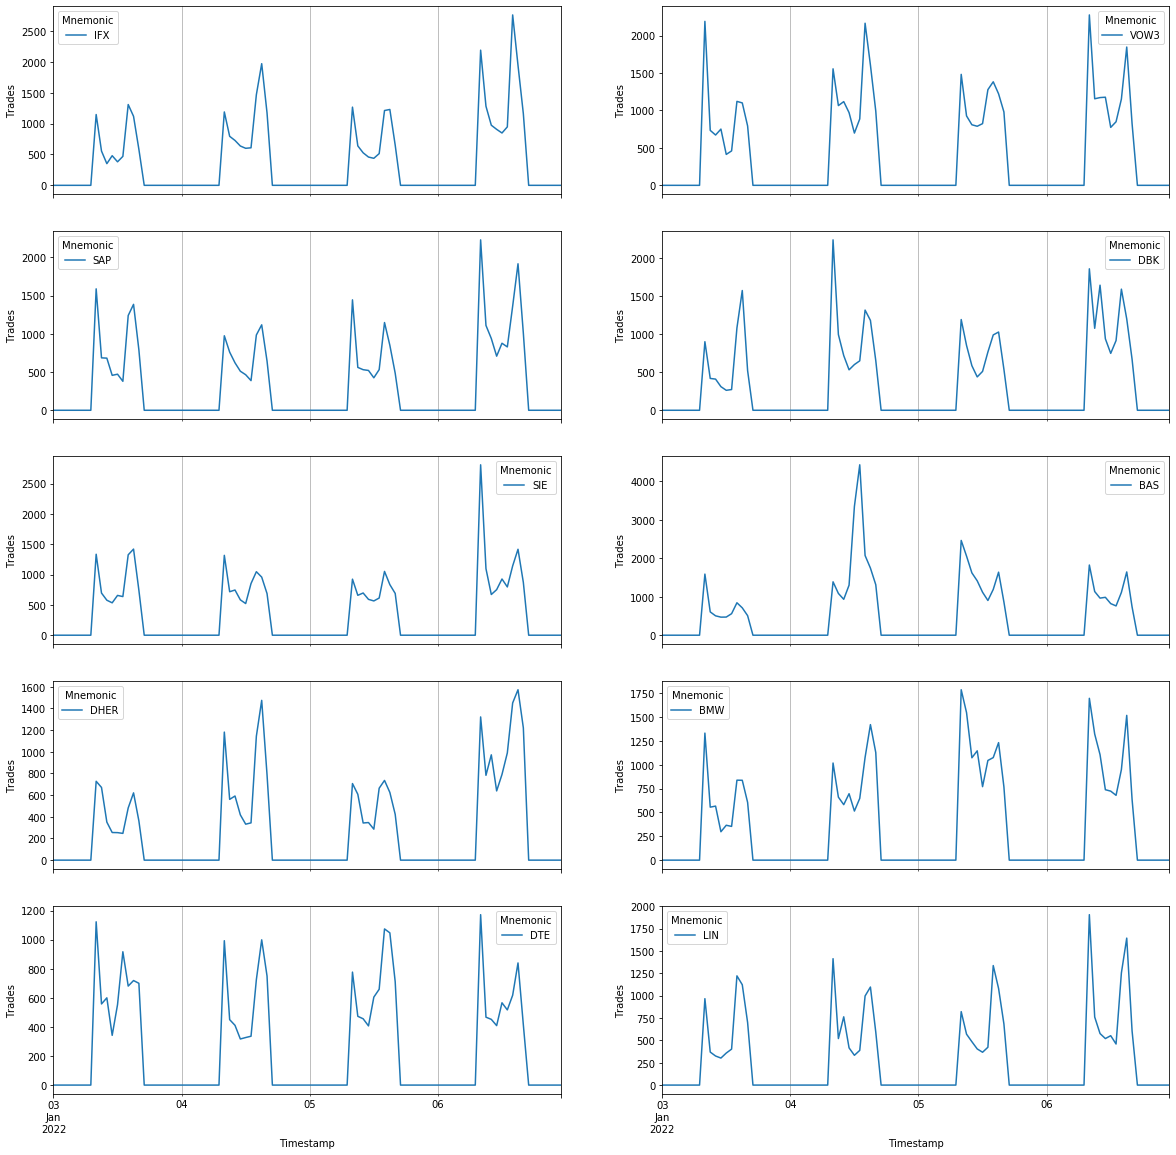

In [12]:
%matplotlib inline

fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    series.loc['2022-01-03':'2022-01-06'][[mnemonics[i]]].plot(ax=axx[i])
    axx[i].set_xlabel("Timestamp")
    axx[i].set_ylabel("Trades")
    axx[i].grid(which="minor", axis="x")

## Datos de entrenamiento y prueba

Cuando trabajamos con datos en series de tiempo la división de los datos debe ser en un punto en el tiempo, es decir, seleccionaremos un ```Timestamp``` para dividir el conjunto de datos. Podemos utilizar los métodos de ```DataFrame``` ```head``` y ```tail``` para entender el rango de tiempo y hacer una división de los datos.

<details><summary>Tip</summary>

Con pandas podemos crear estos "apuntadores" utilizando el constructor de ```Timestamp```.
</details>

<details><summary>Código</summary>

```python
training_start = pd.Timestamp('2022-01-03 08:00:00', freq='1M')
training_stop = pd.Timestamp('2022-02-10 20:00:00', freq='1M')
```
</details>

In [13]:
series.head()

Mnemonic,ADS,ALV,BAS,BAYN,BMW,CBK,CON,DBK,DHER,DPW,DTE,ENR,HFG,IFX,LHA,LIN,MBG,SAP,SIE,VOW3
Timestamp,,,,,,,,,,,,,,,,,,,,
2021-10-01 07:00:00,1510,3117,2510,1905,3124,1330,1394,1816,1328,4939,1223,812,1024,2191,1681,2250,0,2482,2781,2309
2021-10-01 08:00:00,779,1457,848,1068,2582,882,708,897,412,1429,636,305,579,1122,868,1131,0,1041,1286,1568
2021-10-01 09:00:00,835,1047,894,945,1939,506,376,459,249,1215,933,198,354,1395,1236,1199,0,1126,1446,1099
2021-10-01 10:00:00,276,520,443,364,642,441,218,410,235,726,311,430,413,716,950,439,0,512,1253,569
2021-10-01 11:00:00,545,691,682,580,951,504,408,370,340,742,405,355,360,945,993,482,0,636,1157,750


In [14]:
series.tail()

Mnemonic,ADS,ALV,BAS,BAYN,BMW,CBK,CON,DBK,DHER,DPW,DTE,ENR,HFG,IFX,LHA,LIN,MBG,SAP,SIE,VOW3
Timestamp,,,,,,,,,,,,,,,,,,,,
2022-02-28 12:00:00,917,1082,2162,919,1447,1132,861,2264,689,1126,1262,1475,691,957,963,859,2092,815,1311,2879
2022-02-28 13:00:00,992,1237,2630,784,1198,1092,865,1402,1160,1396,1365,1479,785,1165,1589,1324,1881,1361,1465,2020
2022-02-28 14:00:00,1280,1419,2758,1113,1769,1951,1097,2576,1206,1845,1539,1412,1172,1602,1709,1933,2185,1939,2130,2163
2022-02-28 15:00:00,2057,1509,3284,1555,2096,1937,1495,2589,1373,2060,1646,1331,1226,1690,1853,1954,2523,2367,2320,2626
2022-02-28 16:00:00,956,890,1497,673,1217,893,808,1238,797,1142,992,735,851,1101,1279,973,1309,1015,1293,1683


En la siguiente celda podemos manipular el tiempo de inicio y fin del conjunto de datos de entrenamiento.

In [15]:
# Obtenemos el primer indice
training_start = series.index[0]
# Obtenemos el indice correspondiente al final del set de datos menos 7 días
training_stop = series.index[-7 * 24:][0]

Ahora prepararemos las entradas para DeepAR, estos archivos ```JSON``` tienen la siguiente estructura:

```json
{"start": timestamp, "target": [timeseries, ...]}
{"start": timestamp, "target": [timeseries, ...]}
{"start": timestamp, "target": [timeseries, ...]}
{"start": timestamp, "target": [timeseries, ...]}
```

Primero generaremos la entrada para entrenamiento substrayendo los últimos 7 días de nuestro conjunto de datos.
**NOTA: En la manipulación de indices con pandas, el segundo parametro es inclusivo.**

<details><summary>Tip</summary>

Podemos utilizar parte del código utilizado para crear las gráficas para separar las series de tiempo y truncarlas al tamaño correcto.
</details>

<details><summary>Código</summary>

```python
from datetime import timedelta

training_data = [
    {
        'start': str(training_start),
        'target': series.loc[training_start : training_stop - timedelta(days=1)][mnemonic].tolist()
    }
    for mnemonic in mnemonics
]
```
</details>

In [16]:
from datetime import timedelta

training_data = [
    {
        'start': str(training_start),
        'target': series.loc[training_start : training_stop - timedelta(hours=1)][mnemonic].tolist()
    }
    for mnemonic in mnemonics
]
print(len(training_data))

20


Ahora preparemos el conjunto de datos de validación.

In [17]:
test_data = [
    {
        'start': str(training_start),
        'target': series[mnemonic].tolist()
    }
    for mnemonic in mnemonics
]
print(len(training_data))

20


Ahora es necesario colocar estos datos en un balde de S3 desde donde serán leídos por DeepAR.

El archivo con el conjunto de entrenamiento lo nombraremos ```train.json``` y utilizaremos el prefijo definido en la variable ```s3_data_path```.
El archivo con el conjunto de validación lo nombraremos ```test.json``` y de igual forma usaremos el prefijo definido en ```s3_data_path```.

<details><summary>Tip</summary>

Podemos utilizar el serializador de JSON de Python para transformar los diccionarios en arreglos de bytes y el cliente de S3 para cargar los archivos, el método ```put_object``` recibe como parámetro ```Body``` un arreglo de bytes.
</details>

<details><summary>Código</summary>

```python
byte_array = b''
for data in traininng_data:
    byte_array += json.dumps(data).encode('utf-8')
    byte_array += b'\n'

s3_client.put_object(
    Body=byte_array,
    Bucket=bucket,
    Key=f'{s3_data_path}/train/train.json'
)

byte_array = b''
for data in test_data:
    byte_array += json.dumps(data).encode('utf-8')
    byte_array += b'\n'

s3_client.put_object(
    Body=byte_array,
    Bucket=bucket,
    Key=f'{s3_data_path}/test/test.json'
)
```
</details>

In [18]:
byte_array = b''
for data in training_data:
    byte_array += json.dumps(data).encode('utf-8')
    byte_array += b'\n'

s3_client.put_object(
    Body=byte_array,
    Bucket=bucket,
    Key=f'{s3_data_path}/train/train.json'
)

byte_array = b''
for data in test_data:
    byte_array += json.dumps(data).encode('utf-8')
    byte_array += b'\n'

s3_client.put_object(
    Body=byte_array,
    Bucket=bucket,
    Key=f'{s3_data_path}/test/test.json'
)

{'ResponseMetadata': {'RequestId': 'T0FZT7VFJ7RF01PJ',
  'HostId': 'zF+mpOYdwSB7x/as+aK8m9/WW4JeA7dIG3zdjj9sW2jPz+dCvo4GCjmICpxqLv/kvcxKYbQw1r0=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'zF+mpOYdwSB7x/as+aK8m9/WW4JeA7dIG3zdjj9sW2jPz+dCvo4GCjmICpxqLv/kvcxKYbQw1r0=',
   'x-amz-request-id': 'T0FZT7VFJ7RF01PJ',
   'date': 'Fri, 11 Mar 2022 14:18:28 GMT',
   'etag': '"d8c54a52cdaeb521e9391bdbd2f2a9ff"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"d8c54a52cdaeb521e9391bdbd2f2a9ff"'}

## Entrenar un modelo

Aquí necesitamos definir el estimador que lanzará nuestro proceso de entrenamiento. El estimador lo construiremos a partir de ```sagemaker.estimator.Estimator```.
El estimador recibe los siguientes argumentos:

- image_uri - Esta es la imagen que contiene el algoritmo DeepAR, se encuentra en la variable ```image_uri```.
- sagemaker_session - Sesión activa de Amazon SageMaker, la tenemos en la variable ```session```.
- role - Rol para ejecutar tareas de SageMaker, se encuentra en la variable ```role```.
- instance_count - Cantidad de instancias que usaremos para el entrenamiento, en este caso usaremos 1.
- instance_type - Tipo de instancia para realizar el entrenamiento, en este caso usaremos ```ml.c5.2xlarge```.
- base_job_name - Nombre base para la tarea de entrenamiento, usaremos ```xetra-demo```.
- output_path - Ruta de salida para los artefactos de DeepAR, utilizaremos el nombre de nestro balce ```bucket``` y el path de salida ```s3_output_path``` para crear una ruta del tipo ```s3://bucket/path```.

<details><summary>Tip</summary>

Podemos utilizar el serializador de JSON de Python para transformar los diccionarios en arreglos de bytes y el cliente de S3 para cargar los archivos, el método ```put_object``` recibe como parámetro ```Body``` un arreglo de bytes.
</details>

<details><summary>Código</summary>

```python
estimator = sagemaker.estimator.Estimator(
    image_uri=image_uri,
    sagemaker_session=session,
    role=role,
    instance_count=1,
    instance_type='ml.c5.2xlarge',
    base_job_name='xetra-demo',
    output_path=s3_output_path
)
```
</details>

In [19]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_uri,
    sagemaker_session=session,
    role=role,
    instance_count=1,
    instance_type='ml.c5.2xlarge',
    base_job_name='xetra-demo',
    output_path=f's3://{bucket}/{s3_output_path}'
)

Cada algorítmo de aprendizaje de máquina utiliza hiper parámetros para ajustar la forma de ejecución del mismo, en caso de DeepAR podemos revisar la documentación detallada [aquí]().
Cabe mencionar que podríamos utilizar la funcionalidad de tuning automática de SageMaker apoyandonos del objeto [HyperparameterTuner](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html?highlight=HyperparameterTuner) y creando una tarea de optimización de parámetros. En este [blog](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/) podemos ver un ejemplo de como aplicarlo.

In [20]:
# Cantidad de unidades de tiempo que queremos predecir, en este caso horas por siete días
length = 24 * 7

hyperparameters = {
    'time_freq': '1H',
    'epochs': '400',
    'early_stopping_patience': '40',
    'mini_batch_size': '64',
    'learning_rate': '5E-4',
    'context_length': f'{length}',
    'prediction_length': f'{length}',
}
estimator.set_hyperparameters(**hyperparameters)

Ahora lanzamos la tarea de entrenamiento. Esto puede tardar varios minutos dependiendo del tamaño del conjunto de datos utilizado. Para indicar al algoritmo donde se encuentran nuestros datos de entrenamiento y pruebas crearemos un diccionario con las llaves ```train``` y ```test``` para indicarlo.

In [21]:
data_channels = {
    'train': f's3://{bucket}/{s3_data_path}/train/',
    'test': f's3://{bucket}/{s3_data_path}/test/'
}

estimator.fit(inputs=data_channels, wait=True)

2022-03-11 14:19:02 Starting - Starting the training job...
2022-03-11 14:19:04 Starting - Launching requested ML instancesProfilerReport-1647008342: InProgress
.........
2022-03-11 14:21:00 Starting - Preparing the instances for training......
2022-03-11 14:22:01 Downloading - Downloading input data...
2022-03-11 14:22:28 Training - Training image download completed. Training in progress..Arguments: train
[03/11/2022 14:22:30 INFO 139970410604160] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples': '100', 'num_layers': '2', 'test_quantiles': '[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.

## Evaluación del modelo

En el caso de DeepAR las métricas utilizadas para evaluar el modelo son RMSE, mean quantile loss y mean absolute quantile loss. Podemos obtener el detalle de estas métricas a través del objecto ```training_job_analytics```, el cual podemos transformar a un ```DataFrame``` de pandas con el método ```dataframe()```.

<details><summary>Tip</summary>

El nombre de las métricas son ```test:mean_wQuantileLoss``` y ```test:RMSE```.
</details>

<details><summary>Código</summary>

```python
metrics = estimator.training_job_analytics.dataframe()

metrics[metrics['metric_name'].str.startswith('test:')]
```
</details>

In [34]:
metrics = estimator.training_job_analytics.dataframe()

metrics[metrics['metric_name'].str.startswith('test:')]

,timestamp,metric_name,value
0,0.0,test:mean_wQuantileLoss,0.620469
46,0.0,test:RMSE,1036.513924


## Realizar predicciones

Ahora que tenemos nuestro modelo entrenado podemos utilizarlo para realizar predicciones. Es necesario crear un Endpoint y desplegar nuestro modelo en el mismo para poder realizar dichas predicciones.

Comencemos creando la clase hija de ```sagemaker.predictor.Predictor``` que contendrá la lógica necesaria para recibir la petición de predicciones y generar una salida adecuada con las predicciones.

In [22]:
from sagemaker.serializers import IdentitySerializer


class DeepARPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            serializer=IdentitySerializer(content_type='application/json'),
            **kwargs
        )

    def predict(
        self,
        ts,
        cat=None,
        dynamic_feat=None,
        num_samples=100,
        return_samples=False,
        quantiles=['0.25', '0.50', '0.75', '0.90']
    ):
        """
        Solicita la predicción para la serie de tiempo en ts. Opcionalmente se puede incluir su categoría y
         característica dinámica.
        :param ts: Serie de tiempo de pandas.
        :param cat: Categoría opcional.
        :param dynamic_feat: Característica dinámica opcional.
        :param num_samples: Número entero de muestras a calcular, 100 por defecto.
        :param return_samples: Bandera para regresar o no las muestras.
        :param quantiles: Lista de cuantíles a calcular, por defecto [0.25, 0.50, 0.75, 0.90].
        :return: Lista de objetos DataFrame de pandas con las predicciones.
        """
        prediction_time = ts.index[-1] + ts.index.freq
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)

    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = {
            'start': str(ts.index[0]),
            'target': [x for x in ts]
        }
        if cat:
            instance['cat'] = cat
        if dynamic_feat:
            instance['dynamic_feat'] = dynamic_feat
        configuration = {
            'num_samples': num_samples,
            'output_types': ['quantiles', 'samples'] if return_samples else ['quantiles'],
            'quantiles': quantiles
        }
        http_request_data = {
            'instances': [instance],
            'configuration': configuration
        }
        return json.dumps(http_request_data).encode('utf-8')

    def __decode_response(self, response, freq, prediction_time, return_samples):
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.date_range(
            start=prediction_time, freq=freq, periods=prediction_length
        )
        if return_samples:
            dict_of_samples = {
                'sample_' + str(i): s for i, s in enumerate(predictions['samples'])
            }
        else:
            dict_of_samples = {}
        return pd.DataFrame(
            data={**predictions['quantiles'], **dict_of_samples},
            index=prediction_index
        )

    def set_frequency(self, freq):
        self.freq = freq


Una vez creada nuestra clase podemos realizar el despliegue de nuestro modelo, para esta actividad necesitaremos:
- ```initial_instance_count``` - Cantidad de instancias iniciales, usaremos 1.
- ```instance_type``` - Tipo de instancia para la inferencia, usaremos ```ml.m5.large```.
- ```predictor_cls``` - Nuestra clase de predicción ```DeepARPredictor```.

<details><summary>Código</summary>

```python
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    predictor_cls=DeepARPredictor
)
```
</details>

In [23]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    predictor_cls=DeepARPredictor
)

------!

Hagamos una consulta para verificar el Endpoint de inferencia.

In [24]:
predictor.predict(ts=series['BMW'].loc[training_stop:training_stop + timedelta(days=1)]).head()

,0.25,0.50,0.75,0.90
2022-02-22 18:00:00,-8.722709,-5.126536,-1.926158,1.804380
2022-02-22 19:00:00,-3.328207,-1.191506,1.445244,3.279363
2022-02-22 20:00:00,-2.559394,-0.754283,0.951847,3.874183
2022-02-22 21:00:00,0.637812,2.033355,3.684848,5.803832
2022-02-22 22:00:00,-0.858288,1.019451,2.108560,3.648063


Ahora definiremos una función para visualizar las predicciones.

In [25]:
def plot(
    predictor,
    target_ts,
    cat=None,
    dynamic_feat=None,
    forecast_date=training_stop,
    show_samples=False,
    plot_history=7 * 24,
    confidence=80,
):
    freq = target_ts.index.freq
    print(
        f'Invocando ejecución de modelo a partir de {forecast_date}'
    )
    assert confidence > 50 and confidence < 100
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5

    # Primero construimos los argumentos
    args = {
        "ts": target_ts[:forecast_date],
        "return_samples": show_samples,
        "quantiles": [low_quantile, 0.5, up_quantile],
        "num_samples": 100,
    }

    if dynamic_feat:
        args["dynamic_feat"] = dynamic_feat
        fig = plt.figure(figsize=(20, 6))
        ax = plt.subplot(2, 1, 1)
    else:
        fig = plt.figure(figsize=(20, 3))
        ax = plt.subplot(1, 1, 1)

    if cat:
        args["cat"] = cat
        ax.text(0.9, 0.9, "cat = {}".format(cat), transform=ax.transAxes)

    # Llamada al Endpoint
    prediction = predictor.predict(**args)

    # Diagramar las muestras
    if show_samples:
        for key in prediction.keys():
            if "sample" in key:
                prediction[key].plot(color="lightskyblue", alpha=0.2, label="_nolegend_")

    # Diagramar el objetivo
    target_section = target_ts[
        forecast_date - plot_history * freq : forecast_date + 24 * 7 * freq
    ]
    target_section.plot(color="black", label="objetivo")

    # Diagramar el intervalo de confianza y la media predecida
    ax.fill_between(
        prediction[str(low_quantile)].index,
        prediction[str(low_quantile)].values,
        prediction[str(up_quantile)].values,
        color="b",
        alpha=0.3,
        label="{}% de confianza".format(confidence),
    )
    prediction["0.5"].plot(color="b", label="P50")
    ax.legend(loc=2)

    # Ajustar escala, las muestras podrían modificarla
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)

    if dynamic_feat is not None:
        for i, f in enumerate(dynamic_feat, start=1):
            ax = plt.subplot(len(dynamic_feat) * 2, 1, len(dynamic_feat) + i, sharex=ax)
            feat_ts = pd.Series(
                index=pd.date_range(
                    start=target_ts.index[0], freq=target_ts.index.freq, periods=len(f)
                ),
                data=f,
            )
            feat_ts[
                forecast_date - plot_history * freq : forecast_date + prediction_length * freq
            ].plot(ax=ax, color="g")

In [26]:
style = {"description_width": "initial"}

Invocando ejecución de modelo a partir de 2022-02-28 17:00:00


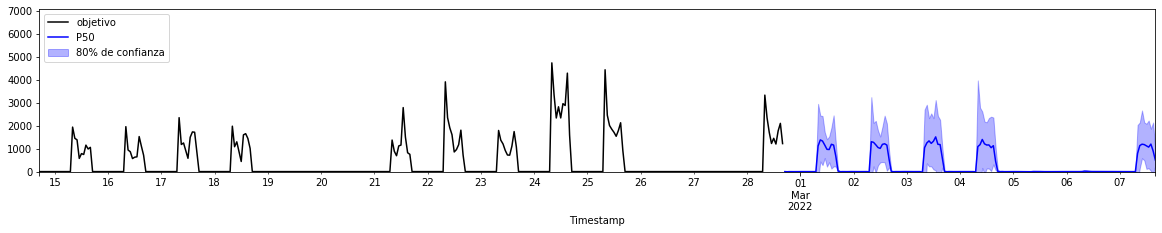

In [28]:
plot(
    predictor,
    target_ts=series['BMW'],
    forecast_date=training_stop + timedelta(days=7),
    show_samples=False,
    plot_history=24 * 14,
    confidence=80
)